# Quesition 2: Finite difference methods

In [ ]:
#Load the usual packages:

import pdb
import numpy as np
import pandas as pd
import scipy.stats as sts
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
from scipy import optimize
import time

In [ ]:
# Market and option parameters
K, r, T = 100, 0.01, 1

# Declare local vol function:
def sigma(t,s):
  return (1+t/30)*(0.1+0.4*np.exp(-s/50))

# Grid parameters
s_min, s_max = 10, 300  # Given by the question
N, M = 4000, 580      # Number of points in each dimension of the grid

# Setup of grids
dt = T/N
dx = (s_max - s_min)/M

# Create the time and price array
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

# Create a jointgrid of the time and price arrays
s_grid, t_grid = np.meshgrid(s, t)

# Compute the values of sigma at each grid point
sigma_grid = sigma(T - t_grid, s_grid)

# We create the vectors for the transformation matrix
A = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

# Print the grid of values of local vol:
#print(sigma_grid)

# Setup the matrix L and I, we have added time dependence compared with the one in the lecture:

def L_n(n):
  a_diag = np.concatenate([A[n,1:-1],[0]])
  b_diag = np.concatenate([[0],B[n,1:-1],[0]])
  c_diag = np.concatenate([[0],C[n,1:-1]])
  L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()

  return L

In [ ]:
#Running the explicit scheme

# Initial condition
v_ex = np.maximum(s - K, 0)     # call option payoff

# Iteration of explicit scheme
I = np.identity(M+1)

start_time = time.time()
for n in range(0,N):

    v_ex = np.matmul(I+L_n(n), v_ex)           # V^{n+1} = (I+L^n)V^n
    v_ex[0] = 0                           # Boundary operation at s_min
    v_ex[M] = s_max - K*np.exp(-r*t[n+1])   # Boundary operation at s_max


end_time = time.time()
time_elapsed = end_time - start_time
print("Time taken: {:.6f} seconds".format(time_elapsed))

Time taken: 19.447445 seconds


In [ ]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [ ]:
# Running the implicit scheme

# Initial condition
v_im = np.maximum(s - K, 0)

start_time = time.time()
# Iteration of implicit scheme
for n in range(1,N+1):
    
    d = v_im   # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at s_min
    d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_min

    # We compute the diagonals which are time dependent:
    a_diag = np.concatenate([A[n,1:-1],[0]])
    b_diag = np.concatenate([[0],B[n,1:-1],[0]])
    c_diag = np.concatenate([[0],C[n,1:-1]])

    v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

end_time = time.time()
time_elapsed = end_time - start_time
print("Time taken: {:.6f} seconds".format(time_elapsed))

Time taken: 4.395309 seconds


In [ ]:
#Crank Nicholson Scheme:

# Initial condition
v_cn = np.maximum(s - K, 0)     # call option payoff

# Iteration of explicit scheme
I = np.identity(M+1)

#Initialise theta for Crank-Nicholson:
theta = 1/2

start_time = time.time()
for n in range(1,N+1):

    # First part of Crank, explicit part:
    d = np.matmul(I+(1-theta)*L_n(n-1), v_cn)           # V^{n+1} = (I+L)V^n
    d[0] = 0                           # Boundary operation at s_min
    d[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

    # Implicit part:
    a_diag = theta * np.concatenate([A[n,1:-1],[0]])
    b_diag = theta * np.concatenate([[0],B[n,1:-1],[0]])
    c_diag = theta * np.concatenate([[0],C[n,1:-1]])
    v_cn = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

end_time = time.time()
time_elapsed = end_time - start_time

print("Time taken: {:.6f} seconds".format(time_elapsed))

#print(v_cn)

Time taken: 22.295575 seconds


In [ ]:
results=pd.DataFrame(v_ex[140:230:10],index=s[140:230:10],columns=['Explicit'])
results['Implicit'] = v_im[140:230:10]
results['Crank-Nicolson'] = v_cn[140:230:10]
results

,Explicit,Implicit,Crank-Nicolson
80.0,0.751150,0.751276,0.751213
85.0,1.475574,1.475556,1.475565
90.0,2.646499,2.646289,2.646394
95.0,4.375359,4.374983,4.375171
100.0,6.729409,6.728962,6.729186
105.0,9.714493,9.714095,9.714294
110.0,13.275724,13.275464,13.275594
115.0,17.314719,17.314622,17.314670
120.0,21.714963,21.714998,21.714981


# Question 2 part B: Implied Volatility

In [ ]:
def price_black_scholes(S0, k, r, t, sigma):
    dpos = (np.log(S0/k) + (r + sigma**2 / 2) / t) / (sigma * np.sqrt(t))
    dneg = dpos - sigma * np.sqrt(t)
    return S0 * sts.norm.cdf(dpos)-k*np.exp(-r*t) * sts.norm.cdf(dneg)
    
def ImpliedVol(S0, k, r, t, C):
    f = lambda sigma: price_black_scholes(S0, k, r, t, sigma)-C
    implied_vol = optimize.brentq(f, 0.0001, 1)
    return implied_vol

In [ ]:
vol = 0.15
price = price_black_scholes(100, 110, 0.03, 2, vol)
ImpliedVol(100, 110, 0.03, 2, price)

0.1499999999998887

In [ ]:
def CrankNicholson(K):
  #Crank Nicholson Scheme:

  # Initial condition
  v_cn = np.maximum(s - K, 0)     # call option payoff

  # Iteration of explicit scheme
  I = np.identity(M+1)

  #Initialise theta for Crank-Nicholson:
  theta = 1/2


  for n in range(1,N+1):

    # First part of Crank, explicit part:
    d = np.matmul(I+(1-theta)*L_n(n-1), v_cn)           # V^{n+1} = (I+L)V^n
    d[0] = 0                           # Boundary operation at s_min
    d[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

    # Implicit part:
    a_diag = theta * np.concatenate([A[n,1:-1],[0]])
    b_diag = theta * np.concatenate([[0],B[n,1:-1],[0]])
    c_diag = theta * np.concatenate([[0],C[n,1:-1]])
    v_cn = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

  return v_cn

In [ ]:
strike_range = np.arange(70,140,10)
m = len(strike_range)
s0, T, r = 100, 1, 0.01
s0_index = np.where(s==s0)[0][0] #Looks for the index with the initial price desired in the grid

IVByStrike = np.zeros(m) #Implied volatility for each strike

for i,k in enumerate(strike_range):
    Call_price = CrankNicholson(k)[s0_index] #index corresponding to an initial price of 100
    IVByStrike[i] = ImpliedVol(s0, k, r, T, Call_price)

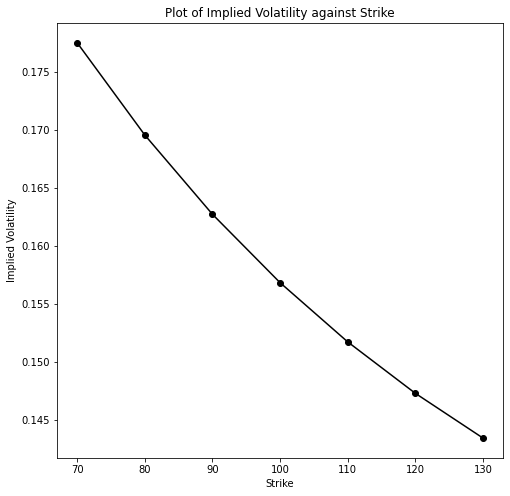

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(strike_range, IVByStrike, '-ok')
plt.title("Plot of Implied Volatility against Strike")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.show()

In [ ]:
pd.DataFrame(IVByStrike,index=strike_range,columns=["Implied Volatility"])

,Implied Volatility
70,0.177546
80,0.169578
90,0.162735
100,0.156829
110,0.151714
120,0.147272
130,0.143408


In [ ]:
#We now create a matrix with constant volatility
sigma_grid_const = np.ones(sigma_grid.shape) * 0.157

#Adjust matrices A,B,C for constant sigma
A = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid_const**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

#Repeat calculation for implied vols
strike_range = np.arange(70,140,10)
m = len(strike_range)
s0, T, r = 100, 1, 0.01
s0_index=np.where(s==s0)[0][0]

IVByStrike = np.zeros(m) #implied volatility for each strike

for i,k in enumerate(strike_range):
    Call_price = CrankNicholson(k)[s0_index] #index corresponding to an initial price of 100
    IVByStrike[i] = ImpliedVol(s0, k, r, T, Call_price)

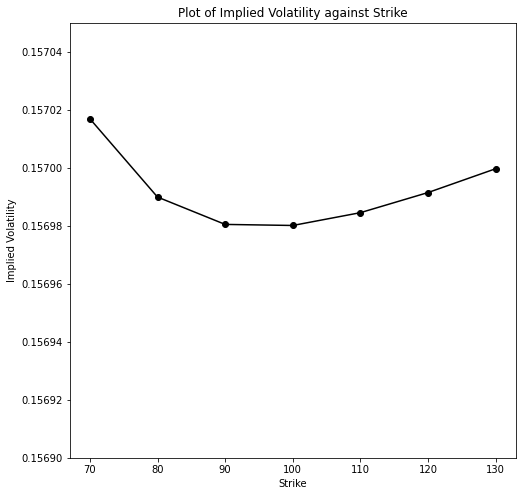

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(strike_range, IVByStrike, '-ok')
plt.ylim(0.1569, 0.15705)
plt.title("Plot of Implied Volatility against Strike")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.show()

In [ ]:
IVByStrike

array([0.15701695, 0.15698994, 0.1569805 , 0.15698013, 0.15698455,
       0.15699149, 0.15699971])

## Down and In Barrier Put

Start with down and out barrier put and use in out parity to get the values of the down and in, as explained in the lecture notes.

First calculate put option under constant and local volatility models

In [ ]:
# Write the grid and model parameters.
# Market and option parameters
K, r, T = 100, 0.01, 1

# Grid parameters
s_min, s_max = 10, 300  # Given by the question
N, M = 4000, 580       # Number of points in each dimension of the grid

# Setup of grids
dt = T/N
dx = (s_max - s_min)/M

# Create the time and price arrays
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

# Create a jointgrid of the time and price arrays
s_grid, t_grid = np.meshgrid(s, t)

# Compute the values of sigma at each grid point
sigma_grid = sigma(T - t_grid, s_grid)

# Adjust A,B,C for local volatility model
A = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

In [ ]:
#Running Crank-Nicholson under the local volatility model:
v_cn = np.maximum(K-s,0)
theta = 1/2
I = np.identity(M+1)

for n in range(1,N+1):
    L_diag_lhs = L_n(n)
    L_diag_rhs = L_n(n-1)
    
    d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
    #apply boundary condition
    d[0]=K
    d[M]=0
    #implicit part of algorithm
    a_diag=np.diag(L_diag_lhs,-1)*theta
    b_diag=np.diag(L_diag_lhs)*theta
    c_diag=np.diag(L_diag_lhs,1)*theta
    v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)

put_local = v_cn

In [ ]:
put_local[180]

5.734169135251788

In [ ]:
#adjust matrices A,B,C for constant sigma
s0=100
K=100
T=1
r=0.01

#We now create a matrix with constant volatility
sigma_grid_const = np.ones(sigma_grid.shape) * 0.157

#Adjust matrices A,B,C for constant sigma
A = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid_const**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

v_cn=np.maximum(K-s,0)
theta=1/2

I= np.identity(M+1)

for n in range(1,N+1):
    L_diag_lhs = L_n(n)
    L_diag_rhs = L_n(n-1)
    
    d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
    #apply boundary condition
    d[0]=K
    d[M]=0
    a_diag=np.diag(L_diag_lhs,-1)*theta
    b_diag=np.diag(L_diag_lhs)*theta
    c_diag=np.diag(L_diag_lhs,1)*theta
    v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)

put_constant=v_cn

In [ ]:
put_constant[180]

5.740143859642652

In [ ]:
def Crank_Nicholson_Barrier(barrier):
    barrier_indicator=(s>barrier)
    v_cn=np.maximum(K-s,0)*barrier_indicator
    theta=1/2
    
    barrier_index=np.where(s==barrier)[0][0] #find the s-index that corresponds to the barrier value

    I= np.identity(M+1)

    for n in range(1,N+1):
        L_diag_lhs = L_n(n)
        L_diag_rhs = L_n(n-1)
 
        d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
        #apply boundary condition
        d[M]=0
        d[0:(barrier_index+1)]=0 #any time the asset prices is at or below the barrier option value is 0 and stays there
        a_diag=np.diag(L_diag_lhs,-1)*theta
        b_diag=np.diag(L_diag_lhs)*theta
        c_diag=np.diag(L_diag_lhs,1)*theta
        v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)
    
    return v_cn

# Down and out

In [ ]:
#first compute the down and out and use in and out parity
#Finite difference is the same as a normal put but we have the extra boundary condition implied by the barrier

#adjust matrices A,B,C for local sigma
s0=100
K=100
T=1
r=0.01

s0_index=np.where(s==s0)[0][0]

# We create the vectors for the transformation matrix
A = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

barrier_range=np.linspace(60,90,4)

local_vol_barrier_do=np.zeros(len(barrier_range))

# Crank-Nicholson
for i,barrier in enumerate(barrier_range):
    local_vol_barrier_do[i]=Crank_Nicholson_Barrier(barrier)[s0_index]

In [ ]:
#adjust matrices A,B,C for constant sigma
s0=100
K=100
T=1
r=0.01

s0_index=np.where(s==s0)[0][0]

# We create the vectors for the transformation matrix
A = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 - 0.5 * r * dt/ dx * s_grid
B = - sigma_grid_const**2 * dt / dx**2 * s_grid**2 - r * dt
C = 0.5 * sigma_grid_const**2 * dt / dx**2 * s_grid**2 + 0.5 * r * dt/ dx * s_grid

barrier_range=np.linspace(60,90,4)

const_vol_barrier_do=np.zeros(len(barrier_range))

# Crank-Nicholson
for i,barrier in enumerate(barrier_range):
    const_vol_barrier_do[i]=Crank_Nicholson_Barrier(barrier)[s0_index]

# Down and In

In [ ]:
#calculate down and in price for both models
local_vol_barrier_di=put_local[s0_index]-local_vol_barrier_do
const_vol_barrier_di=put_constant[s0_index]-const_vol_barrier_do

local_vol_barrier_di

const_vol_barrier_di

vol_model_barrier=pd.DataFrame([local_vol_barrier_di,const_vol_barrier_di]).transpose()
vol_model_barrier.columns=['Local','Constant']
vol_model_barrier.index=barrier_range
vol_model_barrier['%-Difference']=100*(vol_model_barrier['Local']-vol_model_barrier['Constant'])/(vol_model_barrier['Constant'])

vol_model_barrier

,Local,Constant,%-Difference
60.0,0.228248,0.047526,380.262595
70.0,1.224565,0.705231,73.640220
80.0,3.503394,3.099528,13.029907
90.0,5.459331,5.428694,0.564365
